# Exploratory Data Analysis (EDA) for Facial Expressions Dataset

This notebook provides a comprehensive EDA for the facial expressions image dataset. We will analyze class distributions, examine image characteristics, and visualize sample images from each emotion category.

In [29]:
import sys
sys.path.append('..')
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

# Import EDA utility functions
from src.eda_utils import *

# Set plot style
plt.style.use('seaborn-v0_8')
sns.set(style='whitegrid')

# Define paths
TRAIN_PATH = '../dataset/train'
TEST_PATH = '../dataset/test'

## 1. Dataset Overview

Let's first examine the structure of our dataset and count the number of images in each emotion category.

In [30]:
# Create DataFrames for train and test sets 
train_df = build_image_emotion_df(TRAIN_PATH)
test_df = build_image_emotion_df(TEST_PATH)

train_df.head()

,filename,Original Emotion
0,Training_50449107.jpg,happy
1,Training_70433018.jpg,happy
2,Training_85610005.jpg,happy
3,Training_4460748.jpg,happy
4,Training_6312930.jpg,happy


In [31]:
test_df.head()

,filename,Original Emotion
0,PrivateTest_45699463.jpg,happy
1,PrivateTest_61855708.jpg,happy
2,PublicTest_53681781.jpg,happy
3,PrivateTest_52109800.jpg,happy
4,PublicTest_41104919.jpg,happy


In [32]:
# Calculate class distributions from the DataFrames
train_dist = train_df['Original Emotion'].value_counts().reset_index()
train_dist.columns = ['Original Emotion', 'Count']

test_dist = test_df['Original Emotion'].value_counts().reset_index()
test_dist.columns = ['Original Emotion', 'Count']

print("Training Set Distribution:")
print(train_dist)
print("\nTest Set Distribution:")
print(test_dist)

Training Set Distribution:
  Original Emotion  Count
0            happy   7215
1          neutral   4965
2              sad   4830
3             fear   4097
4            angry   3995
5         surprise   3171
6          disgust    436

Test Set Distribution:
  Original Emotion  Count
0            happy   1774
1              sad   1247
2          neutral   1233
3             fear   1024
4            angry    958
5         surprise    831
6          disgust    111


## 2. Visualizing Class Distribution

Let's visualize the distribution of images across different emotion categories.

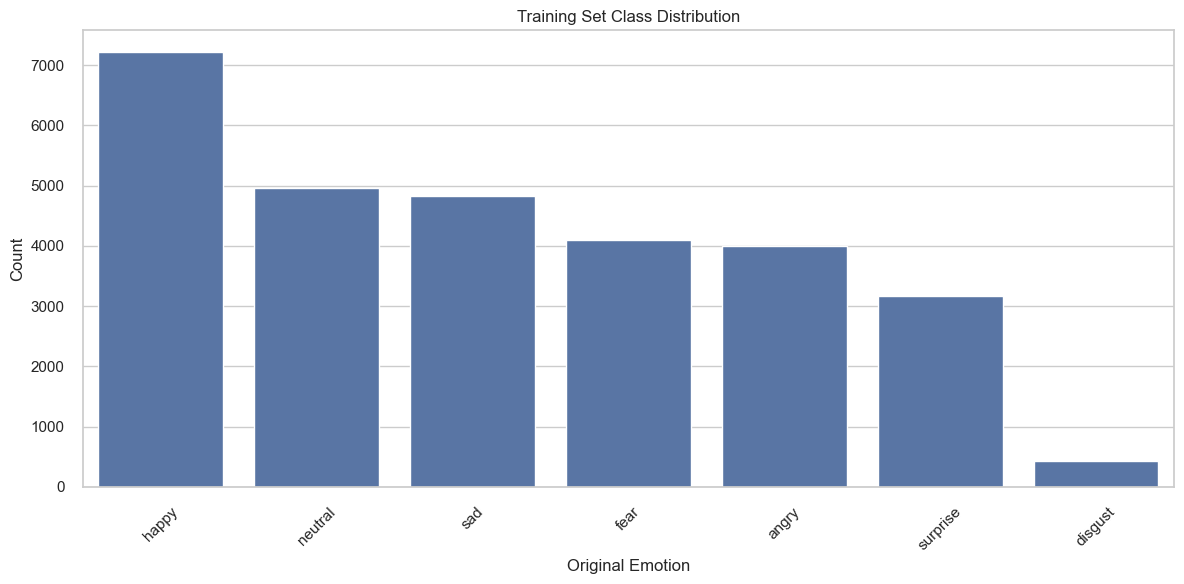

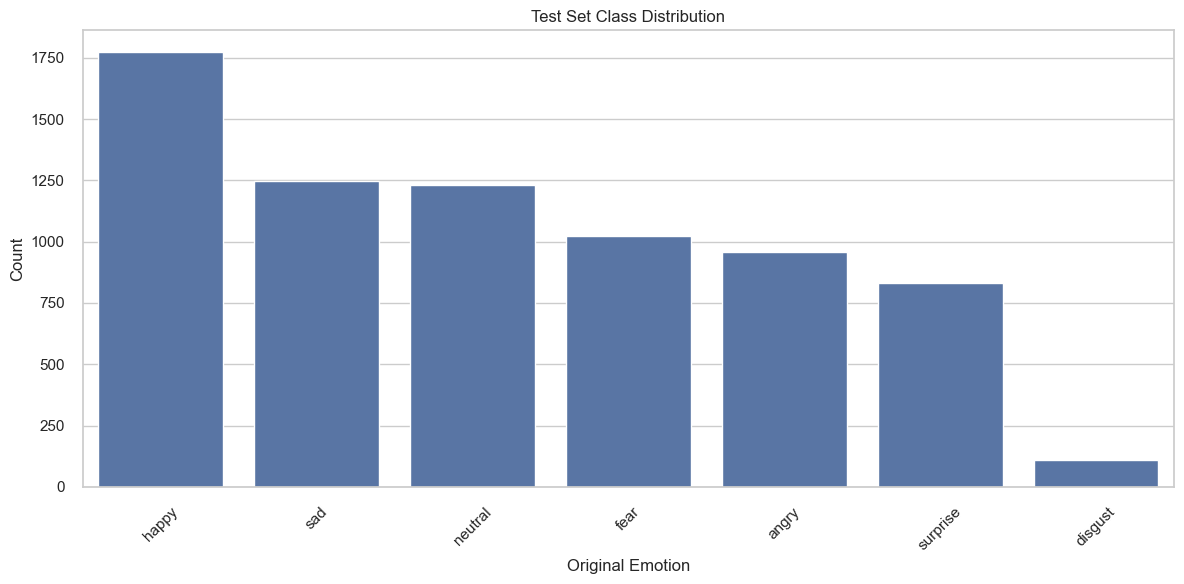

In [33]:
plot_class_distribution(train_dist, x_col='Original Emotion', y_col='Count', title='Training Set Class Distribution')
plot_class_distribution(test_dist, x_col='Original Emotion', y_col='Count', title='Test Set Class Distribution')

## 3. Image Analysis

Let's examine some sample images from each emotion category and analyze their characteristics.


HAPPY:


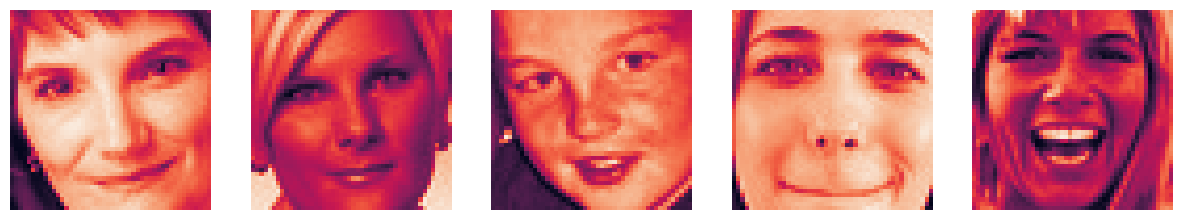


SAD:


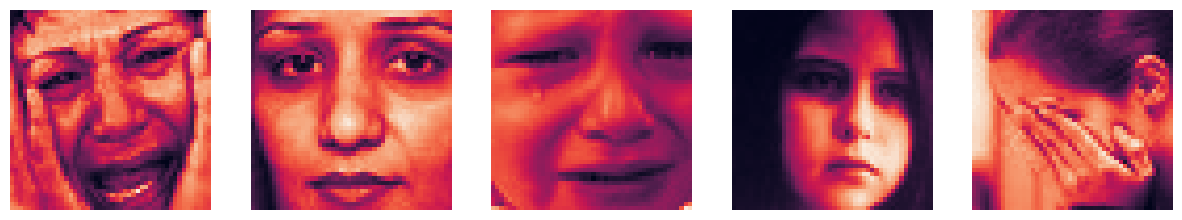


FEAR:


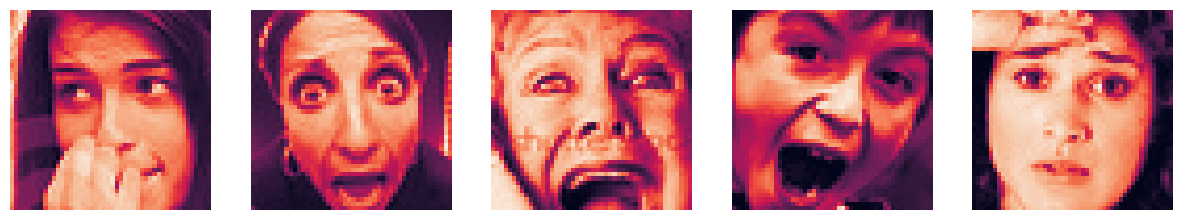


SURPRISE:


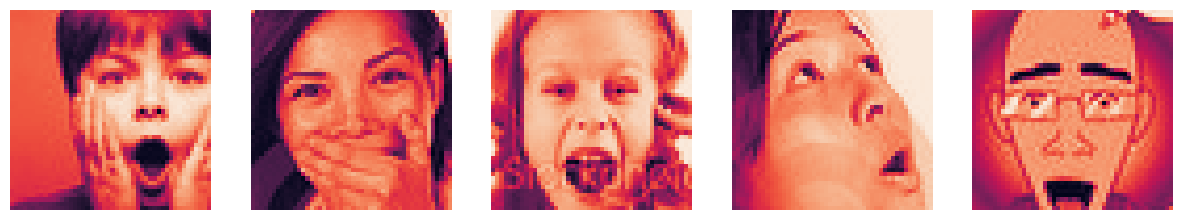


NEUTRAL:


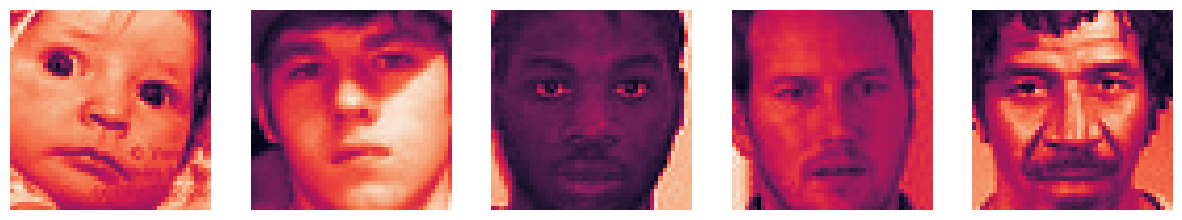


ANGRY:


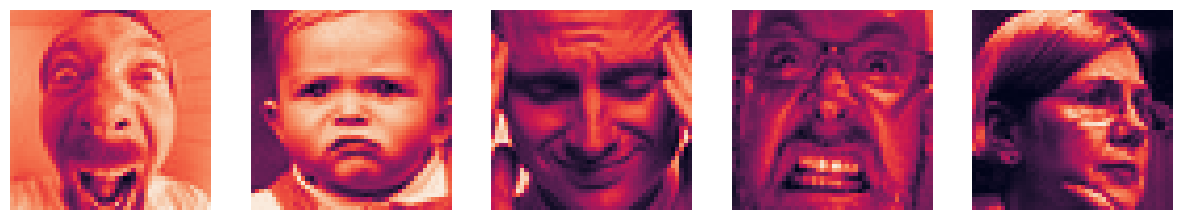


DISGUST:


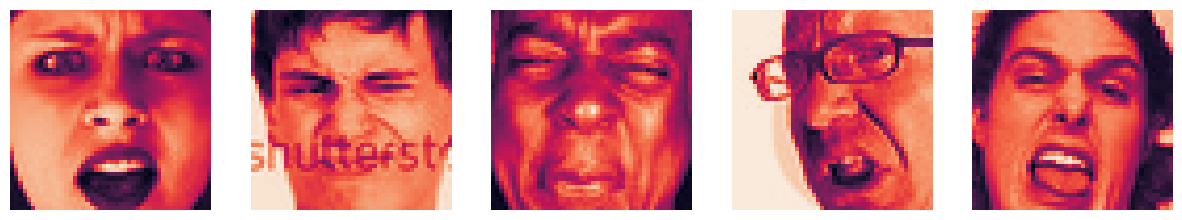

In [34]:
show_sample_images(TRAIN_PATH)

## 4. Class Combination Analysis

In facial expression recognition, some emotions can be difficult to distinguish and may share similar visual characteristics. In our dataset, we observe that 'disgust' and 'angry' expressions often share similar facial features and can be challenging to differentiate. Let's analyze the impact of combining these classes.

In [35]:
# Combine 'disgust' into 'angry' for both training and test sets
train_df['Emotion'] = train_df['Original Emotion'].replace('disgust', 'angry')
test_df['Emotion'] = test_df['Original Emotion'].replace('disgust', 'angry')

In [36]:
# Recalculate the class distributions
# Before combining
train_dist_before = train_df['Original Emotion'].value_counts().reset_index()
train_dist_before.columns = ['Emotion', 'Count']
test_dist_before = test_df['Original Emotion'].value_counts().reset_index()
test_dist_before.columns = ['Emotion', 'Count']

# After combining
train_dist_after = train_df['Emotion'].value_counts().reset_index()
train_dist_after.columns = ['Emotion', 'Count']
test_dist_after = test_df['Emotion'].value_counts().reset_index()
test_dist_after.columns = ['Emotion', 'Count']

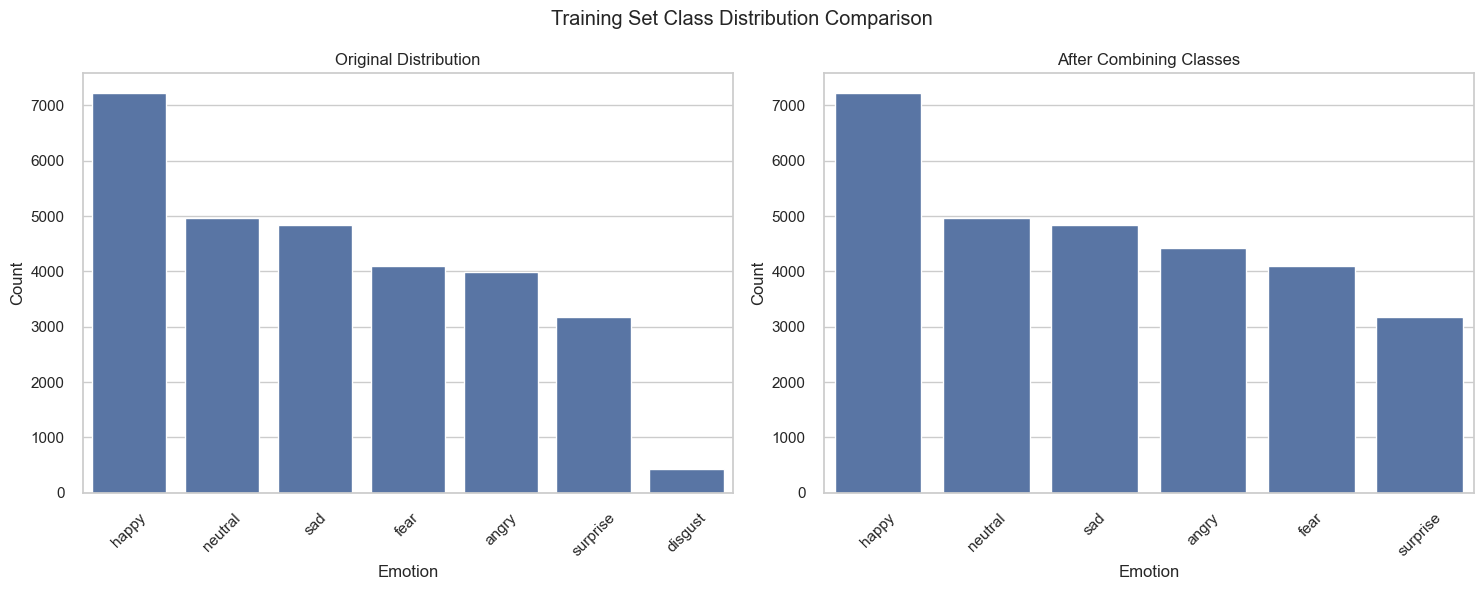

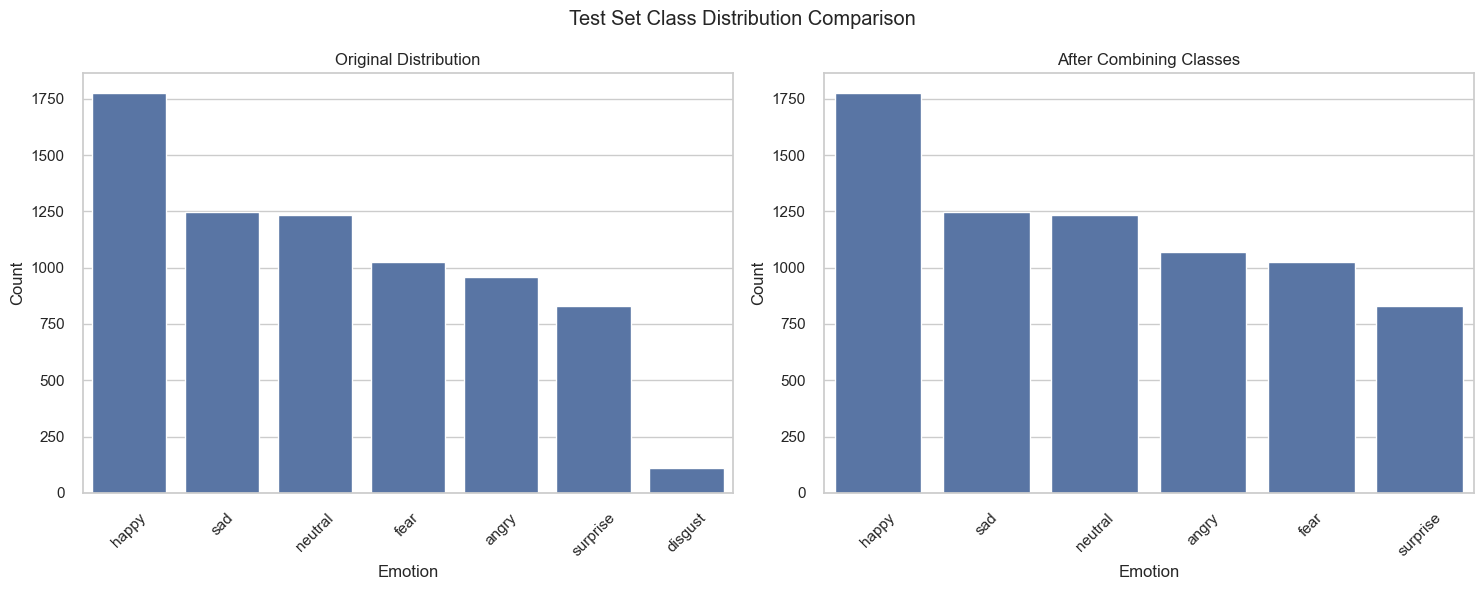

In [37]:
plot_class_comparison(train_dist_before, train_dist_after, x_col='Emotion', y_col='Count', title='Training Set Class Distribution Comparison')
plot_class_comparison(test_dist_before, test_dist_after, x_col='Emotion', y_col='Count', title= 'Test Set Class Distribution Comparison')

In [38]:
# Print the combined distributions
print("Training Set Distribution (After Combining 'disgust' into 'angry'):")
print(train_dist_after)
print("\nTest Set Distribution (After Combining 'disgust' into 'angry'):")
print(test_dist_after)

Training Set Distribution (After Combining 'disgust' into 'angry'):
    Emotion  Count
0     happy   7215
1   neutral   4965
2       sad   4830
3     angry   4431
4      fear   4097
5  surprise   3171

Test Set Distribution (After Combining 'disgust' into 'angry'):
    Emotion  Count
0     happy   1774
1       sad   1247
2   neutral   1233
3     angry   1069
4      fear   1024
5  surprise    831


#### Reasons for Combining Classes:
1. **Similar Facial Features**: Both 'disgust' and 'angry' expressions often involve similar facial muscle movements, particularly around the eyebrows and mouth.
2. **Data Imbalance**: The 'disgust' class typically has fewer samples, which can lead to imbalanced training.
3. **Human Perception**: Humans sometimes struggle to distinguish between these emotions, suggesting they may share similar visual patterns.
4. **Model Performance**: Combining these classes can potentially improve model performance by reducing confusion between similar expressions.

In [39]:
train_df.head()

,filename,Original Emotion,Emotion
0,Training_50449107.jpg,happy,happy
1,Training_70433018.jpg,happy,happy
2,Training_85610005.jpg,happy,happy
3,Training_4460748.jpg,happy,happy
4,Training_6312930.jpg,happy,happy


## 5. Handling Corrupted or Blank Images

During data exploration, we may encounter images that are completely black, blank, or corrupted. These images do not provide useful information for model training and can negatively impact performance. 

**Steps:**
1. **Detect suspect images:** We identify images with very low pixel variance (almost all pixels are the same value), which are likely to be blank or corrupted.
2. **Visual inspection:** Before removing or filtering out these images, we visually inspect them to ensure we are not excluding valid but dark images.
3. **Filter DataFrames:** Instead of deleting files, we filter our DataFrames to exclude these suspect images, ensuring our analysis and modeling use only valid data.

In [40]:
# Detect suspect images
suspect_images = []

for base_path in [TRAIN_PATH, TEST_PATH]:
    for emotion in os.listdir(base_path):
        emotion_path = os.path.join(base_path, emotion)
        if os.path.isdir(emotion_path):
            suspect_images.extend(find_blank_images(emotion_path))

print(f"Found {len(suspect_images)} suspect images.")

Found 14 suspect images.



Displaying 14 images from provided list:


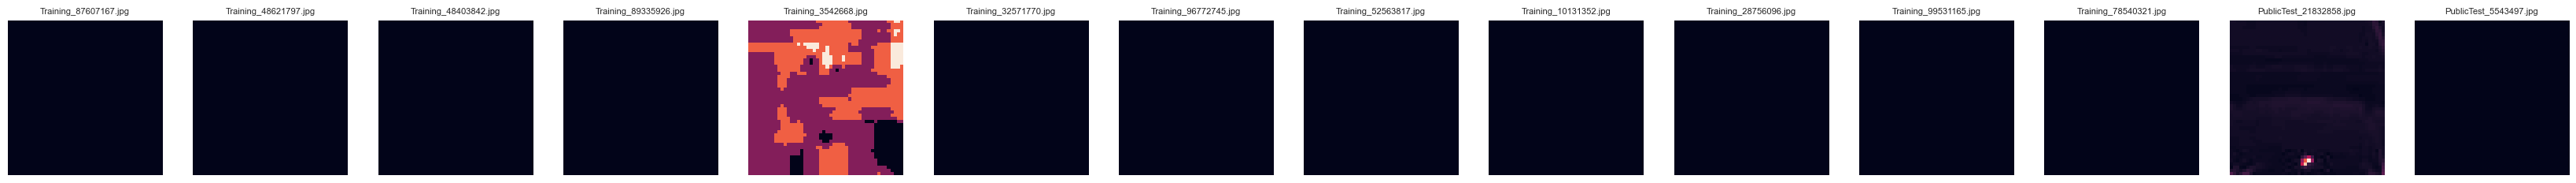

In [41]:
show_sample_images(suspect_images, num_samples=14)

In [42]:
# Get the set of suspect filenames 
suspect_filenames = set(os.path.basename(path) for path in suspect_images)

# Filter train_df and test_df to remove suspect images
filtered_train_df = train_df[~train_df['filename'].isin(suspect_filenames)].reset_index(drop=True)
filtered_test_df = test_df[~test_df['filename'].isin(suspect_filenames)].reset_index(drop=True)

print(f"Original train_df: {len(train_df)} rows")
print(f"Filtered train_df: {len(filtered_train_df)} rows")
print(f"Original test_df: {len(test_df)} rows")
print(f"Filtered test_df: {len(filtered_test_df)} rows")

Original train_df: 28709 rows
Filtered train_df: 28697 rows
Original test_df: 7178 rows
Filtered test_df: 7176 rows


## 6. Final Classes Construction

After experimenting with the full set of emotion classes, we observed that the models required significantly more data to achieve reliable accuracy. Due to limited computational resources, this was not feasible. As a practical solution, we simplified the classification task by merging certain emotion categories and removing those that were either too ambiguous or less relevant. This led to three broader classes: negative (angry and sad), positive (happy), and neutral. 

Such a simplification is particularly useful in applications like customer sentiment recognition, where the goal is to understand overall satisfaction rather than identify specific emotions in detail.

In [43]:
emotion_map = {
    "angry": "negative",
    "sad": "negative",
    "happy": "positive",
    "neutral": "neutral"
}

final_train_df = filtered_train_df.copy()
final_test_df = filtered_test_df.copy()

final_train_df = final_train_df[final_train_df["Emotion"].isin(emotion_map.keys())]
final_test_df = final_test_df[final_test_df["Emotion"].isin(emotion_map.keys())]

final_train_df["Regruped Emotion"] = final_train_df["Emotion"].map(emotion_map)
final_test_df["Regruped Emotion"] = final_test_df["Emotion"].map(emotion_map)

print(final_train_df.head())
print(final_test_df.head())

                filename Original Emotion Emotion Regruped Emotion
0  Training_50449107.jpg            happy   happy         positive
1  Training_70433018.jpg            happy   happy         positive
2  Training_85610005.jpg            happy   happy         positive
3   Training_4460748.jpg            happy   happy         positive
4   Training_6312930.jpg            happy   happy         positive
                   filename Original Emotion Emotion Regruped Emotion
0  PrivateTest_45699463.jpg            happy   happy         positive
1  PrivateTest_61855708.jpg            happy   happy         positive
2   PublicTest_53681781.jpg            happy   happy         positive
3  PrivateTest_52109800.jpg            happy   happy         positive
4   PublicTest_41104919.jpg            happy   happy         positive


In [44]:
original_count = len(filtered_train_df)
final_count = len(final_train_df)

difference = original_count - final_count

removed_count = filtered_train_df[filtered_train_df["Emotion"].isin(["fear", "surprise"])].shape[0]

print(f"Number of images descarted: {difference}")
print(f"Number of images that were classified as 'fear' or 'surprise': {removed_count}")

Number of images descarted: 7267
Number of images that were classified as 'fear' or 'surprise': 7267


In [45]:
# Add the full normalized image path column
TRAIN_IMAGES_DIR = "dataset/train"
TEST_IMAGES_DIR = "dataset/test"
 
final_train_df['image_path'] = final_train_df.apply(
    lambda row: os.path.normpath(os.path.join(TRAIN_IMAGES_DIR, row['Original Emotion'], row['filename'])),
    axis=1
)
final_test_df['image_path'] = final_test_df.apply(
    lambda row: os.path.normpath(os.path.join(TEST_IMAGES_DIR, row['Original Emotion'], row['filename'])),
    axis=1
)

print(final_train_df.head())
print(final_test_df.head())

                filename Original Emotion Emotion Regruped Emotion  \
0  Training_50449107.jpg            happy   happy         positive   
1  Training_70433018.jpg            happy   happy         positive   
2  Training_85610005.jpg            happy   happy         positive   
3   Training_4460748.jpg            happy   happy         positive   
4   Training_6312930.jpg            happy   happy         positive   

                                  image_path  
0  dataset/train/happy/Training_50449107.jpg  
1  dataset/train/happy/Training_70433018.jpg  
2  dataset/train/happy/Training_85610005.jpg  
3   dataset/train/happy/Training_4460748.jpg  
4   dataset/train/happy/Training_6312930.jpg  
                   filename Original Emotion Emotion Regruped Emotion  \
0  PrivateTest_45699463.jpg            happy   happy         positive   
1  PrivateTest_61855708.jpg            happy   happy         positive   
2   PublicTest_53681781.jpg            happy   happy         positive   
3  Pr

## 7. Class Balancing via Downsampling

In facial expression datasets, some emotions appear far more frequently than others, and this imbalance becomes even more pronounced after merging classes. Such skewed distributions can bias the model and lead to unfair or misleading evaluations. To address this, we balanced the dataset by randomly sampling an equal number of images from each class, matching the size of the smallest class.

This approach not only ensures fair training and evaluation, but also helps reduce computational cost, since we have a large number of images. By discarding excess images from majority classes, we make model training more efficient and manageable.

> **Note:** Although this means losing some data, it allows us to train our models faster and with balanced class representation.

In [46]:
# Set the target size for training and test sets
TRAIN_TARGET_SIZE = 9000
TEST_TARGET_SIZE = int(len(final_test_df) * TRAIN_TARGET_SIZE / len(final_train_df))

balanced_train_df = balance_classes(final_train_df, TRAIN_TARGET_SIZE, class_col='Regruped Emotion')
balanced_test_df = balance_classes(final_test_df, TEST_TARGET_SIZE, class_col='Regruped Emotion')

In [47]:
print("After balancing:")
print("Train set class distribution:")
print(balanced_train_df['Regruped Emotion'].value_counts())
print("Test set class distribution:")
print(balanced_test_df['Regruped Emotion'].value_counts())

After balancing:
Train set class distribution:
Regruped Emotion
negative    3000
neutral     3000
positive    3000
Name: count, dtype: int64
Test set class distribution:
Regruped Emotion
negative    744
neutral     744
positive    744
Name: count, dtype: int64


In [51]:
train_dist_balanced = balanced_train_df['Regruped Emotion'].value_counts().reset_index()
train_dist_balanced.columns = ['Emotion', 'Count']
test_dist_balanced = balanced_test_df['Regruped Emotion'].value_counts().reset_index()
test_dist_balanced.columns = ['Emotion', 'Count']

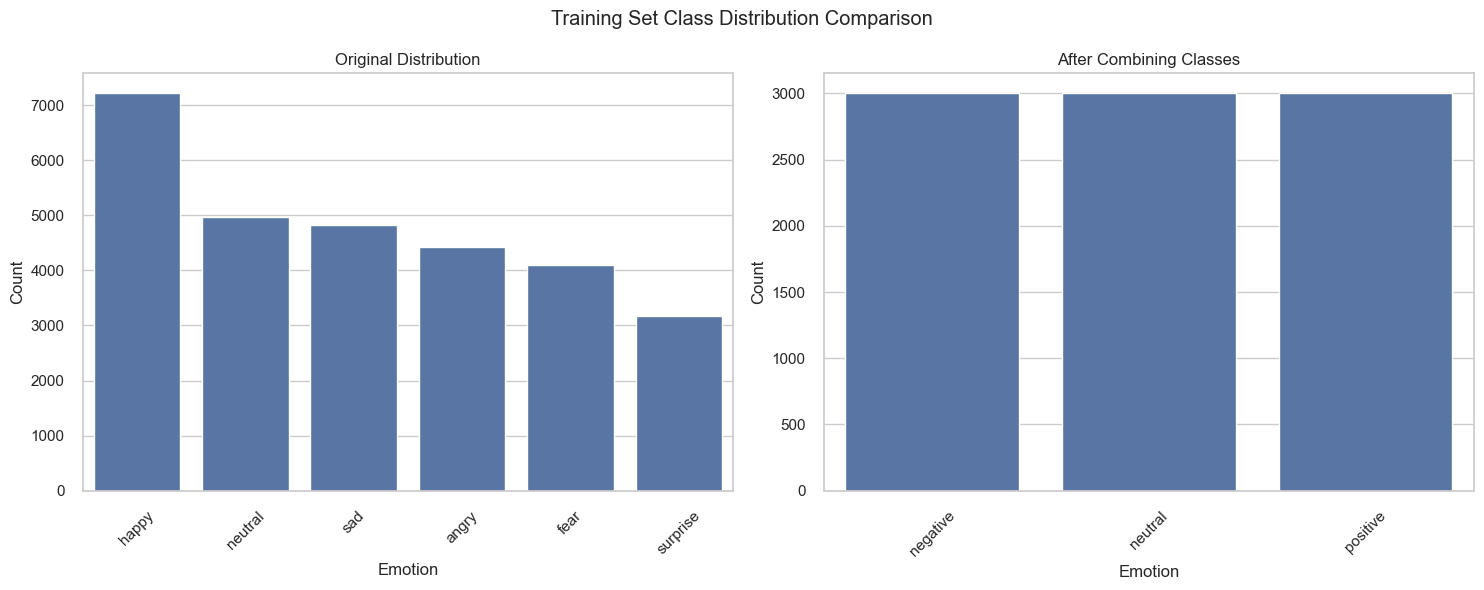

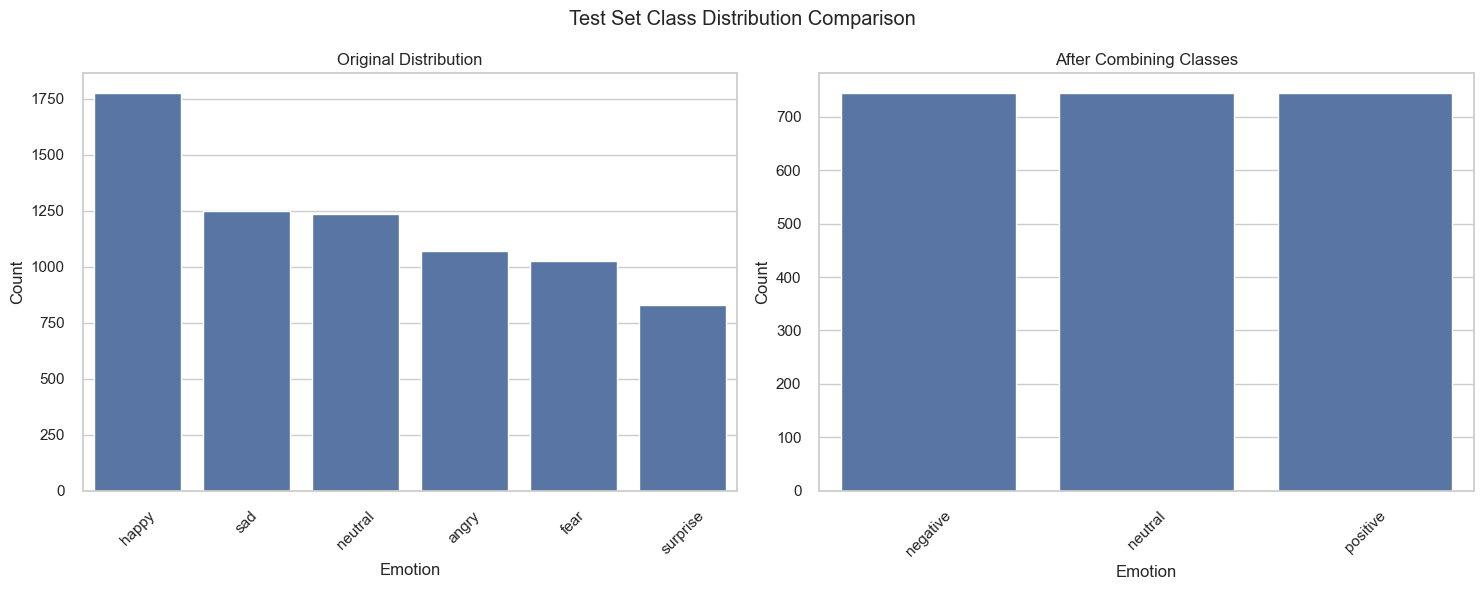

In [52]:
plot_class_comparison(train_dist_after, train_dist_balanced,  x_col='Emotion', y_col='Count', title='Training Set Class Distribution Comparison')
plot_class_comparison(test_dist_after, test_dist_balanced,  x_col='Emotion', y_col='Count', title='Test Set Class Distribution Comparison')

In [ ]:
# Save as CSV
pd.DataFrame(balanced_train_df).to_csv("../dataset/balanced_train_regruped_classes.csv", index=False)
pd.DataFrame(balanced_test_df).to_csv("../dataset/balanced_test_regruped_classes.csv", index=False)

In [53]:
print(f"Original train_df: {len(train_df)} rows")
print(f"Balanced train_df: {len(balanced_train_df)} rows")
print(f"Original test_df: {len(test_df)} rows")
print(f"Balanced test_df: {len(balanced_test_df)} rows")

Original train_df: 28709 rows
Balanced train_df: 9000 rows
Original test_df: 7178 rows
Balanced test_df: 2232 rows


## 8. Image Statistics

Let's analyze the dimensions and other characteristics of the images in our dataset.

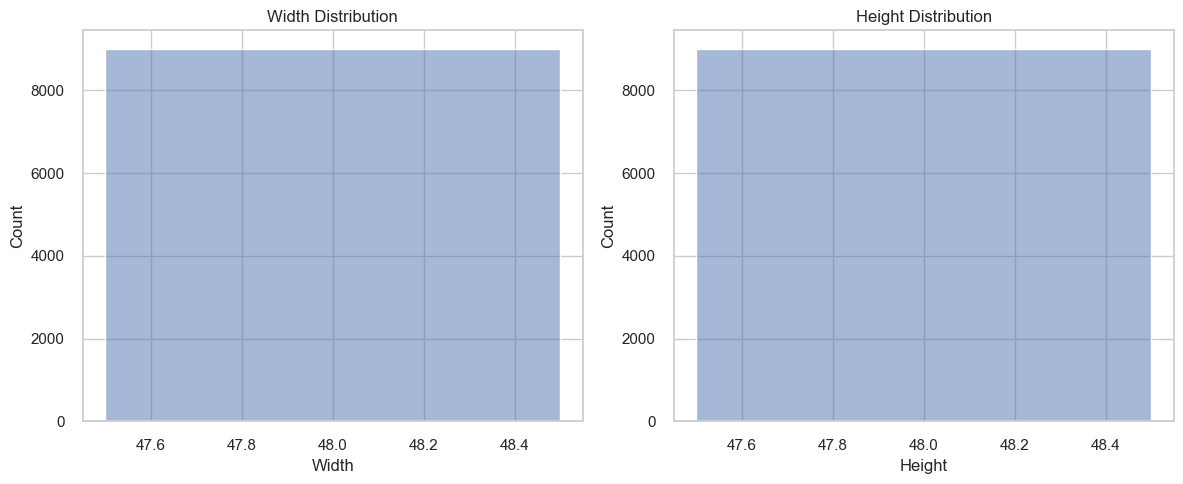

Image Dimension Statistics:
        Width  Height
count  9000.0  9000.0
mean     48.0    48.0
std       0.0     0.0
min      48.0    48.0
25%      48.0    48.0
50%      48.0    48.0
75%      48.0    48.0
max      48.0    48.0


In [54]:
images_path = balanced_train_df["image_path"].apply(lambda x: os.path.normpath(os.path.join("..", x)))
analyze_image_dimensions(images_path)

The histograms show the distribution of image widths and heights in the dataset. Both distributions are extremely narrow, with all images having exactly the same dimensions (48x48 pixels). This indicates that the dataset is highly standardized in terms of image size, which is beneficial for model training as it eliminates the need for additional resizing or preprocessing steps related to image dimensions.

## 9. Color Distribution Analysis

Let's analyze the color distribution (RGB histograms) of the images to understand the color characteristics of our dataset.

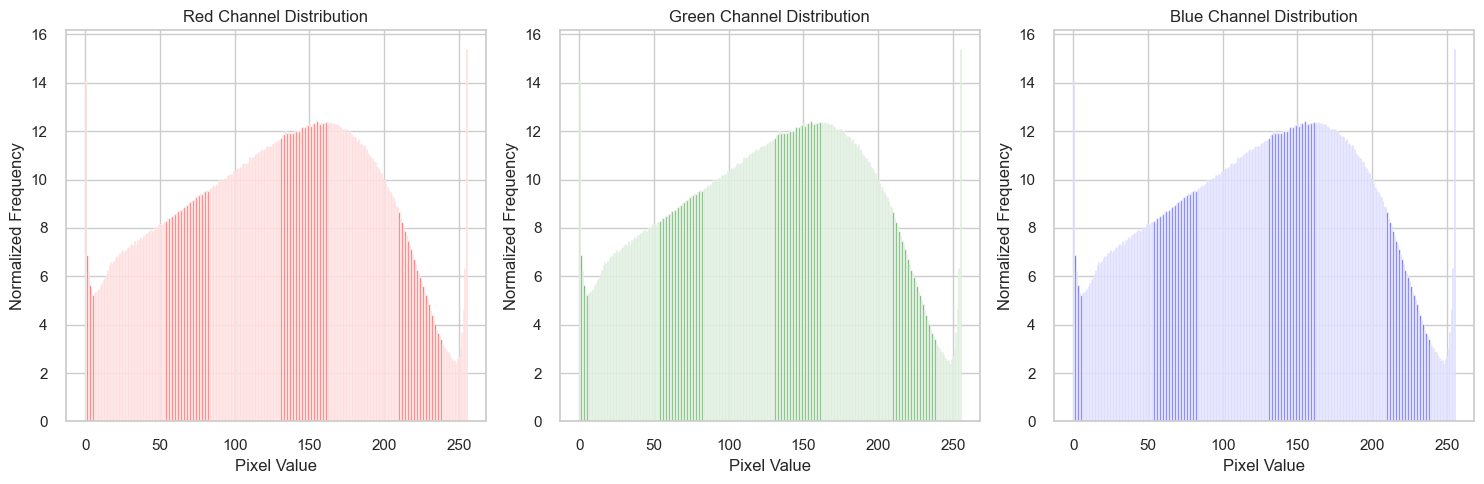

In [55]:
analyze_color_distribution(images_path)

The plots show the normalized pixel value distributions for the Red, Green, and Blue channels across the dataset. The distributions are relatively broad, indicating a good range of color intensities in the images. There is a noticeable peak at the higher pixel values (close to 255) in all channels, suggesting that many images contain bright or white regions.

Overall, the dataset appears to have a diverse color composition, which is beneficial for training robust models.

## 10. Pixel Value Distribution

Let's analyze the distribution of pixel values across the dataset to understand the overall brightness and contrast characteristics.

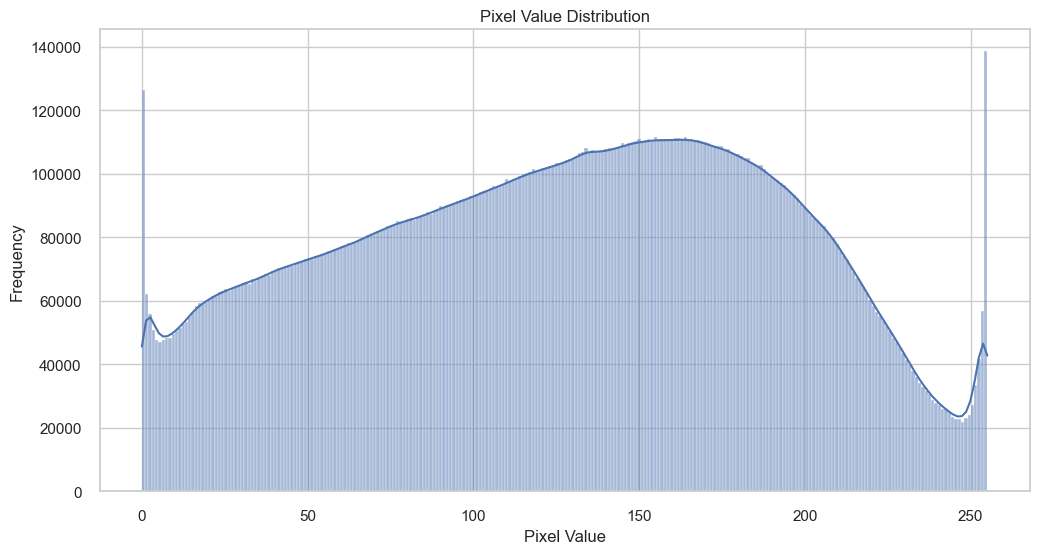

Pixel Value Statistics:
Mean: 126.53
Standard Deviation: 64.68
Min: 0
Max: 255


In [56]:
analyze_pixel_distribution(images_path)

The histogram above shows the distribution of grayscale pixel values across the dataset. The pixel values span the full range from 0 (black) to 255 (white), with a mean of approximately 131 and a standard deviation of about 65. This indicates a good spread of brightness levels in the images.

There are noticeable peaks at both ends of the spectrum (near 0 and 255), suggesting the presence of both very dark and very bright regions in the images—possibly due to background, lighting, or contrast in facial features. The relatively even distribution in the middle range indicates that the dataset contains a variety of mid-tone pixels as well.

Overall, this distribution suggests that the images are well-contrasted and diverse in terms of brightness, which is beneficial for training robust models.